This Jupyter notebook creates a geographic heatmap visualization of police incident density across Scottish data zones using log-normalized incident counts, mapping the data onto 2011 data zone boundaries to reveal spatial patterns of crime and incident distribution.

In [1]:
import sys
import numpy.core.numeric as core_numeric
import types

# Create a dummy module named "numpy._core.numeric"
shim = types.ModuleType("numpy._core.numeric")
shim.__dict__.update(core_numeric.__dict__)
sys.modules["numpy._core.numeric"] = shim

import pickle
with open('processed_data_v1.pkl', 'rb') as f:
    df = pickle.load(f)

/tmp/dcs-tmp.u2164966/ipykernel_1576339/4197079368.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("dzone_code", as_index=False)["incident_count"]


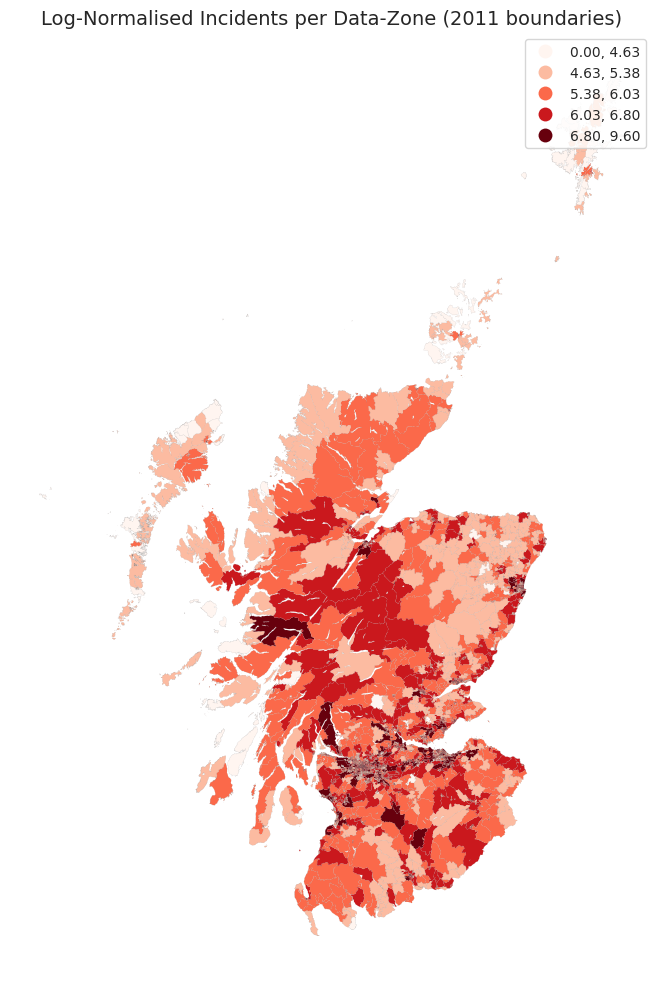

In [51]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np  # <-- Needed for log transformation

# 1. Incident counts per Data-Zone
df_counts = (
    df.groupby("dzone_code", as_index=False)["incident_count"]
      .sum()
      .rename(columns={"incident_count": "n_incidents"})
)

# 2. Read Data-Zone polygons from local shapefile
shp_path = "shape_files/SG_DataZone_Bdry_2011.shp"
gdf_dz = gpd.read_file(shp_path)

# 3. Join counts → polygons + project to WGS84
gdf = (
    gdf_dz.merge(df_counts, left_on="DataZone", right_on="dzone_code", how="left")
          .fillna({"n_incidents": 0})
          .to_crs(epsg=4326)
)

# --- LOG NORMALISATION HERE ---
gdf["log_n_incidents"] = np.log1p(gdf["n_incidents"])  # log(x+1), safe for zeros

# 4. Heatmap using the log-normalised column
fig, ax = plt.subplots(1, 1, figsize=(9, 10))
gdf.plot(
    column="log_n_incidents",      
    ax=ax,
    cmap="Reds",
    scheme="natural_breaks",  
    k=5,
    legend=True,
    edgecolor="grey",
    linewidth=0.05
)
ax.set_title("Log-Normalised Incidents per Data-Zone (2011 boundaries)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()
